# Feature importance and ensembles of decision trees

In this notebook, we see two different ways that several trees can be combined into a single classifier. We compare the performance of these to that of a single tree, and see that this can ameliorate several of the drawbacks of a single decision tree.

As always, we start by loading the relevant modules:

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn # for visualizations

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.datasets import load_breast_cancer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### The dataset: breast cancer

Here we load the dataset, and explore it a little bit. We then split it into a training and testing set.

In [3]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

Let's also take a quick look at the data. We will look at it as a Pandas dataframe to get a nice printout :-) 

In [5]:
pd.DataFrame(cancer.data, columns=cancer.feature_names)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


The data is split into a test and training set:

In [8]:
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target,random_state=0)

### A single decision tree

We first train a single decision tree on the data:

In [9]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [10]:
print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

Accuracy on training set: 0.986
Accuracy on test set: 0.909


### Feature importance

Aggregated over the whole tree, how much is each feature used to predict the label? 

In [11]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.01558601 0.         0.         0.         0.
 0.         0.         0.01150064 0.         0.00253726 0.
 0.01023272 0.01043016 0.         0.         0.         0.
 0.         0.         0.03848579 0.03087626 0.75708572 0.
 0.         0.         0.00418952 0.10976588 0.         0.00931004]


Let's plot this in a more useful manner:

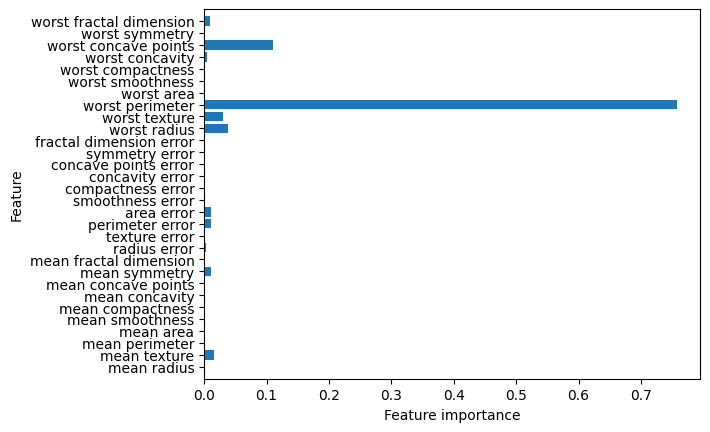

In [13]:
def plot_feature_importance_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importance_cancer(tree)

We see that the tree rates "worst radius" as the most important feature. How do you interpret this result?

### Random forest 

One way to improve decision trees is just to train a lot of them! This requires a few extra parameters:
- n_estimators: determines how many trees are trained
- max_features: how many features should each tree choose between at each split

In [14]:
forest = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=10, random_state=0)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, max_features=10, random_state=0)

In [16]:
print("Accuracy on training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(x_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.944


Compare this to the feature importance we obtained for a single tree!

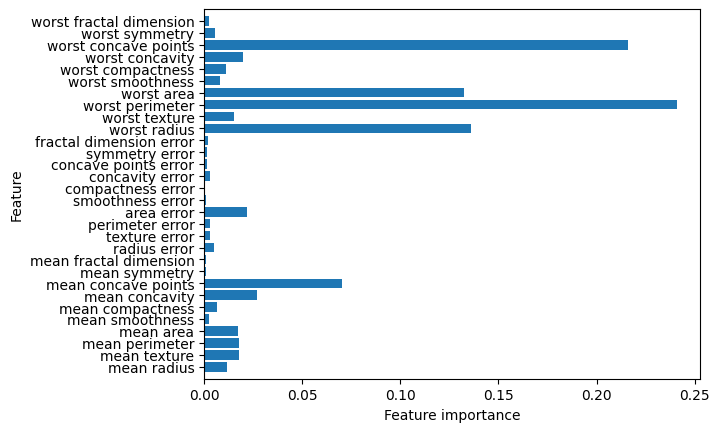

In [17]:
plot_feature_importance_cancer(forest)

### Gradient boosted trees

Instead of just blindly building many trees, one could use each tree to improve the next. This requires yet another set of parameters:
- n_estimators: how many trees to train
- max_depth: How deep each tree should be (usually small for Boosted trees)
- learning_rate: How strongly does each tree learn from the previous one?

In [27]:
gpt = GradientBoostingClassifier(random_state=0, n_estimators=100,max_depth=3,learning_rate=0.01)
gpt.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [28]:
print("Accuracy on training set: {:.3f}".format(gpt.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gpt.score(x_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.944


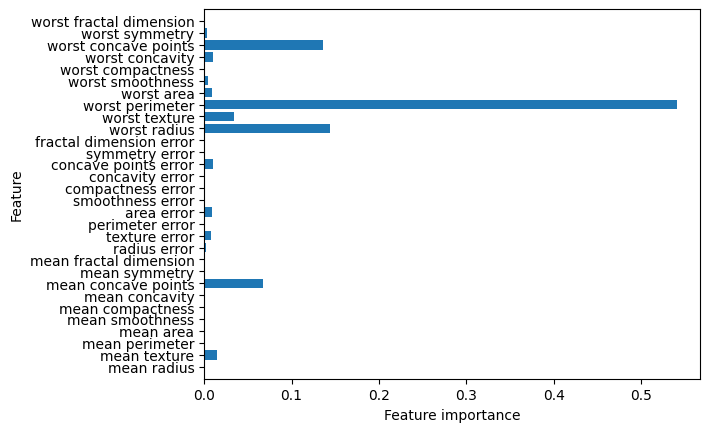

In [29]:
plot_feature_importance_cancer(gpt)